# Mount Google Drive

In [ ]:
# Google Colab specific integration
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Required Packages

In [ ]:
print("📦 Installing required packages...")

!pip install -q torch torchvision
!pip install -q scikit-learn
!pip install -q umap-learn
!pip install -q pillow
!pip install -q matplotlib seaborn
!pip install -q tqdm
!pip install -q pyyaml
!pip install rarfile

print("✅ All packages installed successfully!")

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 118.2 MB/s eta 0:00:00
✅ All packages installed successfully!


# Create project root in Google Drive

In [ ]:
import os
PROJECT_ROOT = '/content/drive/MyDrive/image-clustering-retrieval'
os.makedirs(PROJECT_ROOT, exist_ok=True)

# Create folder structure
folders = [
    'data/raw',
    'data/processed',
    'features',
    'models/pretrained',
    'models/clustering',
    'models/classifier',
    'models/faiss_index',
    'results/clustering',
    'results/retrieval/sample_queries',
    'results/classification',
    'configs'
]

for folder in folders:
    os.makedirs(f'{PROJECT_ROOT}/{folder}', exist_ok=True)

print("✅ Project structure created!")
print(f"📁 Project root: {PROJECT_ROOT}")

# Change working directory
os.chdir(PROJECT_ROOT)
print(f"📂 Current directory: {os.getcwd()}")

✅ Project structure created!
📁 Project root: /content/drive/MyDrive/image-clustering-retrieval
📂 Current directory: /content/drive/MyDrive/image-clustering-retrieval


In [ ]:
#  Set random seeds
import torch
import numpy as np
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# check for GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


# Extract Caltech-101 Dataset from RAR (Colab Local Storage)

In [ ]:
import os
import rarfile

print("=" * 60)
print("EXTRACTING CALTECH-101 DATASET INTO PROCESSED FOLDER (GOOGLE DRIVE)")
print("=" * 60)

# Install RAR support (run once per runtime)
!apt-get -qq install unrar
!pip install -q rarfile

# Path to uploaded RAR file (RAW source)
uploaded_rar_path = "/content/drive/MyDrive/image-clustering-retrieval/data/raw/object.rar"

# Target directory (PROCESSED)
processed_dir = "/content/drive/MyDrive/image-clustering-retrieval/data/processed"
dataset_path = os.path.join(processed_dir, "object")

# Sanity check: RAR exists
if not os.path.exists(uploaded_rar_path):
    raise FileNotFoundError(
        f"❌ RAR file not found at {uploaded_rar_path}"
    )

# Create processed directory if missing
os.makedirs(processed_dir, exist_ok=True)

# Extract only if not already extracted
if not os.path.exists(dataset_path):
    print("📦 Extracting dataset into processed folder...")

    with rarfile.RarFile(uploaded_rar_path) as rf:
        rf.extractall(processed_dir)

    print("✅ Extraction complete!")
else:
    print("✅ Dataset already exists — skipping extraction")

# Verify dataset structure
if not os.path.exists(dataset_path):
    raise RuntimeError("❌ Extraction failed: 'object/' folder not found!")

# Dataset stats
categories = sorted([
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith(".")
])

total_images = sum(
    len([
        f for f in os.listdir(os.path.join(dataset_path, c))
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    for c in categories
)

print("\n📊 Dataset Statistics:")
print(f"   Total categories: {len(categories)}")
print(f"   Total images: {total_images}")
print(f"\n📁 Dataset location (PROCESSED): {dataset_path}")

EXTRACTING CALTECH-101 DATASET INTO PROCESSED FOLDER (GOOGLE DRIVE)
📦 Extracting dataset into processed folder...
✅ Extraction complete!

📊 Dataset Statistics:
   Total categories: 50
   Total images: 4696

📁 Dataset location (PROCESSED): /content/drive/MyDrive/image-clustering-retrieval/data/processed/object


# Create Custom Dataset Class

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm

class ObjectDataset(Dataset):
    """
    Custom Dataset for Caltech-style object dataset
    Folder structure:
    /content/object/
        ├── accordion/
        ├── airplanes/
        ├── ...
    """

    def __init__(self, root_dir="/content/object", transform=None, max_images_per_class=None):
        self.root_dir = root_dir
        self.transform = transform
        self.max_images_per_class = max_images_per_class

        # Get class folders
        self.categories = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])

        self.category_to_idx = {cat: idx for idx, cat in enumerate(self.categories)}

        self.image_paths = []
        self.labels = []

        print(f"📂 Found {len(self.categories)} categories")

        for category in tqdm(self.categories, desc="Scanning categories"):
            cat_path = os.path.join(root_dir, category)
            cat_idx = self.category_to_idx[category]

            images = [
                f for f in os.listdir(cat_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]

            if max_images_per_class:
                images = images[:max_images_per_class]

            for img in images:
                self.image_paths.append(os.path.join(cat_path, img))
                self.labels.append(cat_idx)

        print(f"✅ Loaded {len(self.image_paths)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color="black")

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_category_name(self, idx):
        return self.categories[idx]

# PHASE 1: DATA PREPARATION"

------------------------------------------------------------
PHASE 1: DATA PREPARATION
------------------------------------------------------------
📂 Found 50 categories


Scanning categories: 100%|██████████| 50/50 [00:00<00:00, 577.00it/s]

✅ Loaded 4696 images

📊 Dataset created:
   Total images: 4696
   Total categories: 50
✅ Metadata saved

🎨 Visualizing sample images...


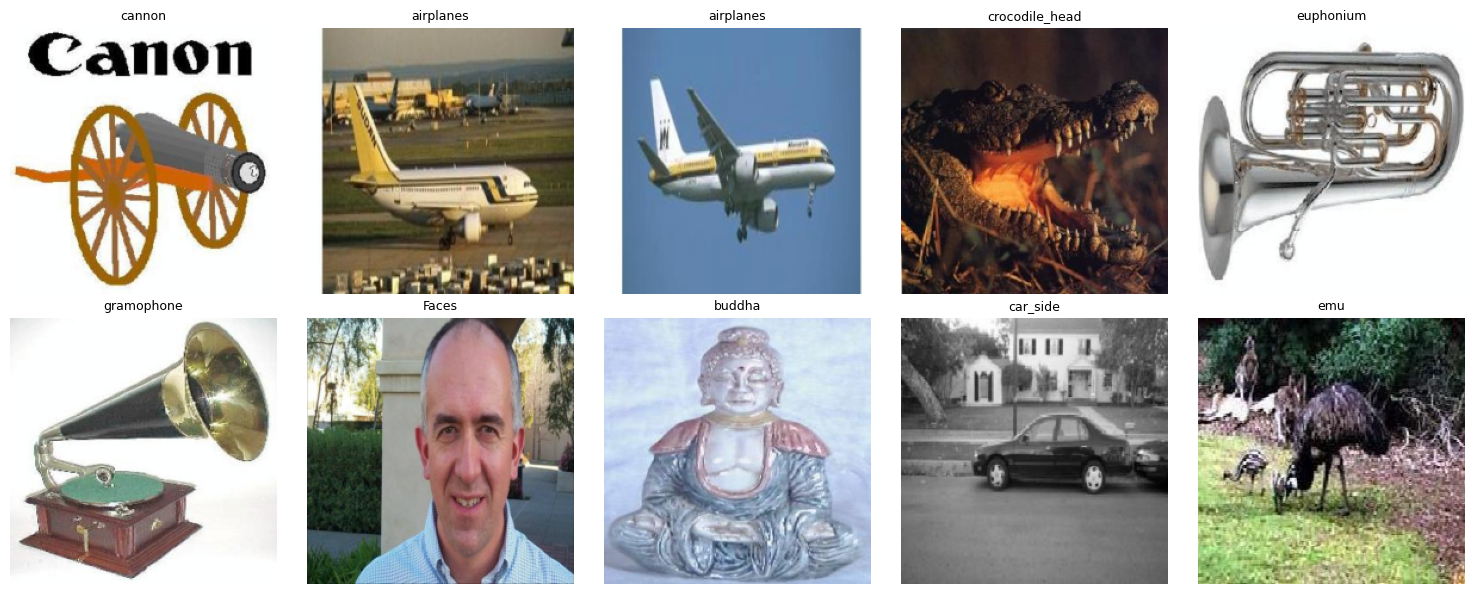

In [ ]:
import torchvision.transforms as transforms
import json
from datetime import datetime
import matplotlib.pyplot as plt

print("-"*60)
print("PHASE 1: DATA PREPARATION")
print("-"*60)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ Use CORRECT dataset class
full_dataset = ObjectDataset(
    root_dir=dataset_path,   # /content/object
    transform=transform,
    max_images_per_class=None
)

print(f"\n📊 Dataset created:")
print(f"   Total images: {len(full_dataset)}")
print(f"   Total categories: {len(full_dataset.categories)}")

# Save metadata
metadata = {
    "num_categories": len(full_dataset.categories),
    "num_images": len(full_dataset),
    "categories": full_dataset.categories,
    "category_to_idx": full_dataset.category_to_idx,
    "dataset_path": dataset_path,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

os.makedirs(f"{PROJECT_ROOT}/configs", exist_ok=True)

with open(f"{PROJECT_ROOT}/configs/dataset_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved")

# Visualize samples
def visualize_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, ax in enumerate(axes):
        img, label = dataset[indices[i]]

        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(dataset.get_category_name(label), fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

print("\n🎨 Visualizing sample images...")
visualize_samples(full_dataset)

# PHASE 2: FEATURE EXTRACTION

## Feature Extraction with ResNet-50

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import normalize
from tqdm import tqdm
import os
from PIL import Image
import torchvision.transforms as transforms

print("-"*60)
print("PHASE 2: FEATURE EXTRACTION")
print("-"*60)

# --- Start: Re-definitions for kernel stability ---
# This block ensures essential variables are defined even after a kernel restart.
# Ideally, previous cells (byqToj4MW1nX, zlz_pNMtYJYY, uL1P5rKvkEm9, F6ZHVlZOkG1j, YBO9SlEiXayz)
# should be executed first.

# Define PROJECT_ROOT if not already in scope (from byqToj4MW1nX)
if 'PROJECT_ROOT' not in globals():
    PROJECT_ROOT = '/content/drive/MyDrive/image-clustering-retrieval'
    os.makedirs(PROJECT_ROOT, exist_ok=True)
    print(f"Re-defined PROJECT_ROOT: {PROJECT_ROOT}")

# Define dataset_path if not already in scope (from zlz_pNMtYJYY)
if 'dataset_path' not in globals():
    processed_dir = os.path.join(PROJECT_ROOT, "data/processed")
    dataset_path = os.path.join(processed_dir, "object")
    os.makedirs(processed_dir, exist_ok=True)
    print(f"Re-defined dataset_path: {dataset_path}")

# Define ObjectDataset class if not already in scope (from uL1P5rKvkEm9)
if 'ObjectDataset' not in globals():
    print("Re-defining ObjectDataset class...")
    class ObjectDataset(Dataset):
        """
        Custom Dataset for Caltech-style object dataset
        Folder structure:
        /content/object/
            ├── accordion/
            ├── airplanes/
            ├── ...
        """
        def __init__(self, root_dir, transform=None, max_images_per_class=None):
            self.root_dir = root_dir
            self.transform = transform
            self.max_images_per_class = max_images_per_class
            self.categories = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
            self.category_to_idx = {cat: idx for idx, cat in enumerate(self.categories)}
            self.image_paths = []
            self.labels = []
            for category in tqdm(self.categories, desc="Scanning categories (re-init)", leave=False):
                cat_path = os.path.join(root_dir, category)
                cat_idx = self.category_to_idx[category]
                images = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if max_images_per_class:
                    images = images[:max_images_per_class]
                for img in images:
                    self.image_paths.append(os.path.join(cat_path, img))
                    self.labels.append(cat_idx)
        def __len__(self):
            return len(self.image_paths)
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            try:
                image = Image.open(img_path).convert("RGB")
            except:
                image = Image.new("RGB", (224, 224), color="black")
            if self.transform:
                image = self.transform(image)
            return image, label
        def get_category_name(self, idx):
            return self.categories[idx]

# Define transform if not already in scope (from F6ZHVlZOkG1j)
if 'transform' not in globals():
    print("Re-defining transform...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

# Define full_dataset if not already in scope (from F6ZHVlZOkG1j)
if 'full_dataset' not in globals():
    print("Re-initializing full_dataset...")
    full_dataset = ObjectDataset(
        root_dir=dataset_path,
        transform=transform,
        max_images_per_class=None
    )
    print(f"   full_dataset re-initialized with {len(full_dataset)} images.")

# Define device if not already in scope (from YBO9SlEiXayz)
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Re-defined device: {device}")
# --- End: Re-definitions for kernel stability ---

class FeatureExtractor:
    def __init__(self, model_name='resnet50', device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model_name = model_name

        print(f"\n🔧 Loading pretrained {model_name}...")

        if model_name == 'resnet50':
            model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.feature_dim = 2048
        else:
            raise ValueError("Only resnet50 supported")

        self.model = nn.Sequential(*list(model.children())[:-1])
        self.model.to(self.device)
        self.model.eval()

        print(f"✅ Model loaded on {self.device}")
        print(f"   Feature dimension: {self.feature_dim}")

    def extract_features(self, dataloader, desc="Extracting features"):
        features_list = []
        labels_list = []

        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc=desc):
                images = images.to(self.device)

                features = self.model(images)
                features = features.view(features.size(0), -1)

                features_list.append(features.cpu().numpy())
                labels_list.append(labels.numpy())

        features = np.vstack(features_list)
        labels = np.concatenate(labels_list)

        return features, labels
# Dataloader
batch_size = 64
dataloader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Feature extractor
extractor = FeatureExtractor(model_name='resnet50', device=device)

print(f"\n📊 Extracting features from {len(full_dataset)} images...")

features, labels = extractor.extract_features(dataloader)

# Normalize
features_normalized = normalize(features, norm='l2')

# Save
os.makedirs(f"{PROJECT_ROOT}/features", exist_ok=True)

np.save(f"{PROJECT_ROOT}/features/embeddings.npy", features_normalized)
np.save(f"{PROJECT_ROOT}/features/labels.npy", labels)
print("✅ Feature extraction & saving complete!")

------------------------------------------------------------
PHASE 2: FEATURE EXTRACTION
------------------------------------------------------------

🔧 Loading pretrained resnet50...
✅ Model loaded on cuda
   Feature dimension: 2048

📊 Extracting features from 4696 images...


Extracting features: 100%|██████████| 74/74 [00:29<00:00,  2.55it/s]


✅ Feature extraction & saving complete!
